<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/Classifiers_with_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/7bf0971e-4d5c-47f4-abc5-4c29d6735f27

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [2]:
np.random.seed(42) #The random seed helps in the reproduction of the results

# Download necessary NLTK data

In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Load the dataset
df = pd.read_excel('posts.xlsx')

# Text preprocessing: Tokenization, Lemmatization, etc

In [5]:
# Text preprocessing: Tokenization, Lemmatization, etc
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

df['cleaned_text'] = df['Question_body'].apply(preprocess_text)


# Save the updated DataFrame to an Excel file

In [6]:
df.to_excel('posts.xlsx', index=False)

In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-09 09:51:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-09 09:51:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-09 09:51:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!unzip glove.6B.zip -d "/content/drive/My Drive/Thesis_Musenga/"

# Load GloVe Embeddings from Google Drive
In future sessions, you can load the embeddings directly from Google Drive without having to download and unzip them again:
https://chatgpt.com/share/31751243-a735-41ad-b1a6-0e7952f9b67e

import os

glove_dir = "/content/drive/My Drive/Thesis_Musenga/"

embeddings_index = {}
#Replace "glove.6B.100d.txt" with the specific GloVe file you need.
with open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Loaded %s word vectors." % len(embeddings_index))

# Load the embeddings:
 Load the GloVe embeddings into a dictionary for easy access.

In [9]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)
print(f'Found {len(glove_embeddings)} word vectors.')

Found 400000 word vectors.


# Convert question to embedding

In [10]:
# Convert question to embedding
def question_to_embedding(question, embeddings_index, embedding_dim=100):
    words = question.split()
    embeddings = [embeddings_index.get(word, np.zeros(embedding_dim)) for word in words]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

In [11]:
# Prepare features and labels
X = np.array([question_to_embedding(q, glove_embeddings) for q in df['cleaned_text']])
y = df['Label'].astype(int).values

# Train-test split

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes with Glove

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [14]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [15]:
# Predict on the test set
y_pred = nb_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}')

Overall Accuracy: 0.697641375390736
Class 0 - Precision: 0.8970588235294118, Recall: 0.7300531914893617, F1-score: 0.8049853372434017, Support: 1504
Class 1 - Precision: 0.7697107203630176, Recall: 0.9150370869858395, F1-score: 0.836105976586568, Support: 1483


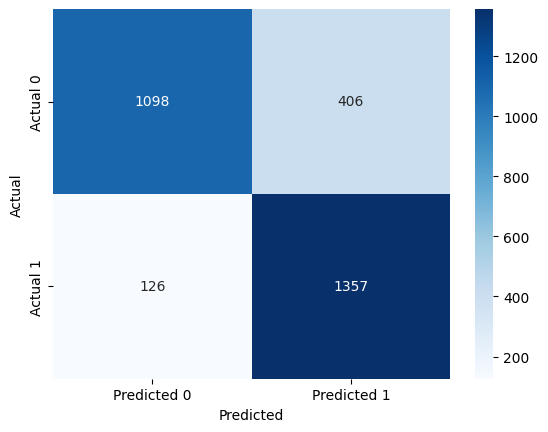

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# kNN with Glove

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_pred = knn_model.predict(X_test)

In [19]:
# Predict on the test set
y_pred = knn_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}')

Overall Accuracy: 0.7524200645350543
Class 0 - Precision: 0.8503886010362695, Recall: 0.8730053191489362, F1-score: 0.8615485564304464, Support: 1504
Class 1 - Precision: 0.8676368676368676, Recall: 0.8442346594740391, F1-score: 0.8557758031442241, Support: 1483


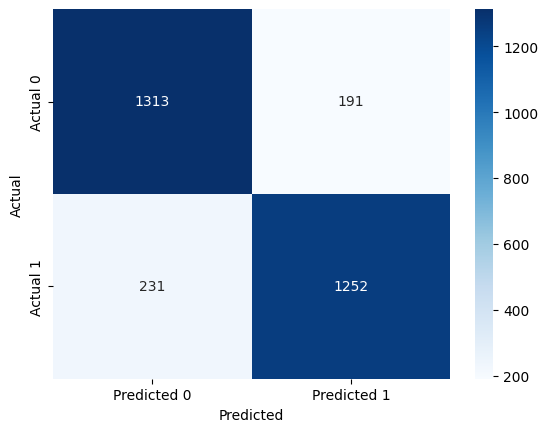

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decison Tree with Glove

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)

In [22]:
# Predict on the test set
y_pred = dt_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}')

Overall Accuracy: 0.697641375390736
Class 0 - Precision: 0.8184796854521625, Recall: 0.8304521276595744, F1-score: 0.8244224422442245, Support: 1504
Class 1 - Precision: 0.8254620123203286, Recall: 0.813216453135536, F1-score: 0.8192934782608695, Support: 1483


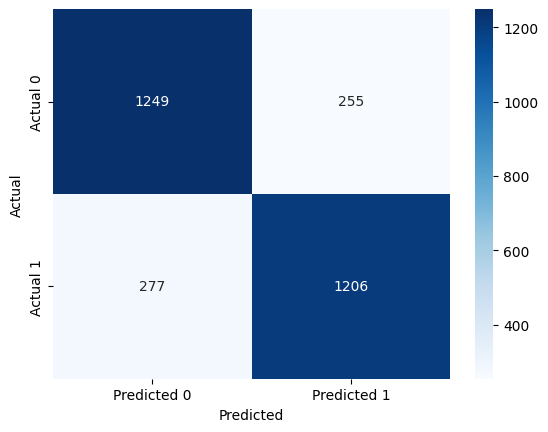

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression with Glove

In [24]:
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model = lg_model.fit(X_train, y_train)

In [25]:
# Predict on the test set
y_pred = lg_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}')

Overall Accuracy: 0.8415536374845869
Class 0 - Precision: 0.9255972696245733, Recall: 0.901595744680851, F1-score: 0.9134388683058269, Support: 1504
Class 1 - Precision: 0.9027595269382391, Recall: 0.9265003371544167, F1-score: 0.9144758735440932, Support: 1483


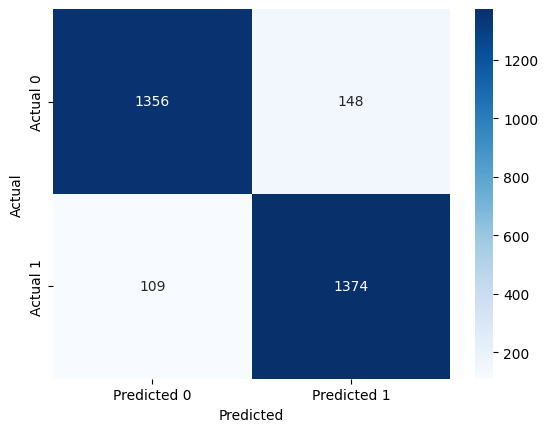

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM with GloVe

In [27]:
# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [28]:
# Predict and evaluate
y_pred = svm_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute precision, recall, and F1-score for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate overall accuracy
accuracy = (TP_0 + TP_1) / (TP_0 + TP_1 + FP_0 + FP_1 + FN_0 + FN_1)

print(f'Overall Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}')

Overall Accuracy: 0.846676970633694
Class 0 - Precision: 0.9343015214384509, Recall: 0.8982712765957447, F1-score: 0.9159322033898306, Support: 1504
Class 1 - Precision: 0.9007138221933809, Recall: 0.9359406608226568, F1-score: 0.9179894179894181, Support: 1483


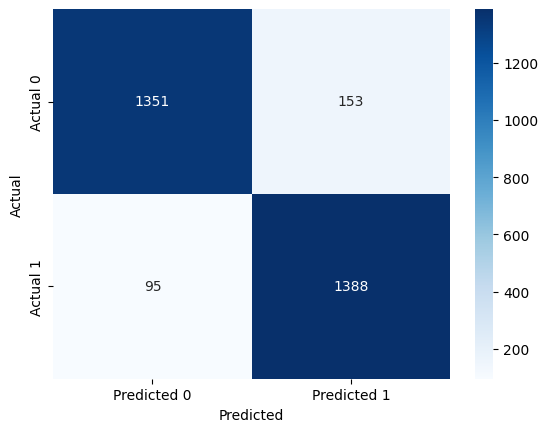

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()